In [869]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras.layers import Dense
from keras.models import Sequential
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa

In [870]:
listings_df = pd.read_csv('../data/processed/processed_listings.csv').dropna()
len(listings_df)

110317

In [871]:
listings_df.head()

,subtype,style,living_area,lot_dimensions,bedrooms,bathrooms,levels,location,listing_year,listing_date,year_of_construction,price
0,2 Storey,2 storey,1191,4076,3,1,2,Capitale-Nationale,2020.0,2020-12-01,2004,332500
1,Bungalow,Open area,1261,9500,2,1,1,Mauricie,2021.0,2021-12-01,1957,265000
2,Townhouse,Unknown,1645,1360,3,1,3,Lachine,2021.0,2021-11-01,2006,612000
3,Bi-generation,Link,2024,17000,4,3,1,Capitale-Nationale,2021.0,2021-12-01,2019,526500
4,Semi-detached,2 storey,2400,4471,4,2,2,Outaouais,2021.0,2021-12-01,1989,360000


## Correlation Heat Map

In [872]:
sns.set_theme(style="white")

def plot_corr_map(df):
    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(8, 6))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

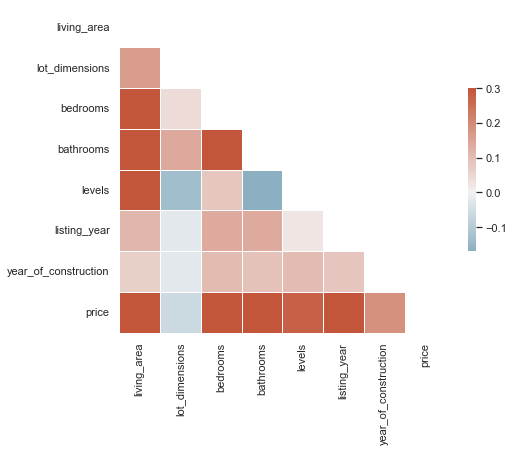

In [873]:
plot_corr_map(listings_df)

## Choosing columns

In [874]:
ordinal_cols = ['listing_year', 'year_of_construction', 'subtype']
one_hot_cols = ['location']
numerical_cols = ['living_area', 'lot_dimensions', 'bedrooms', 'bathrooms', 'levels']
target_col = ['price']

In [875]:
listings_df = listings_df[ordinal_cols + one_hot_cols + numerical_cols + target_col]
listings_df.head()

,listing_year,year_of_construction,subtype,location,living_area,lot_dimensions,bedrooms,bathrooms,levels,price
0,2020.0,2004,2 Storey,Capitale-Nationale,1191,4076,3,1,2,332500
1,2021.0,1957,Bungalow,Mauricie,1261,9500,2,1,1,265000
2,2021.0,2006,Townhouse,Lachine,1645,1360,3,1,3,612000
3,2021.0,2019,Bi-generation,Capitale-Nationale,2024,17000,4,3,1,526500
4,2021.0,1989,Semi-detached,Outaouais,2400,4471,4,2,2,360000


## One Hot Encoding

In [876]:
def oh_encode(df_line, col, new_col, val):
    if df_line[col] == val:
        return df_line[new_col] + 1
    else:
        return df_line[new_col]

for col in one_hot_cols:
    for val in listings_df[col].unique():   
        new_col = str(val) + '_' + col
        listings_df[new_col] = 0
        listings_df[new_col] = listings_df.apply(oh_encode, args=(col, new_col, val), axis=1)

    listings_df = listings_df.drop(columns=[col])

In [877]:
listings_df.head()

,listing_year,year_of_construction,subtype,living_area,lot_dimensions,bedrooms,bathrooms,levels,price,Capitale-Nationale_location,...,Le Plateau-Mont-Royal_location,Anjou_location,Îles-de-la-Madeleine_location,Le Sud-Ouest_location,Verdun_location,Nord-du-Québec_location,Ville-Marie_location,Saint-Léonard_location,Côte-des-Neiges–Notre-Dame-de-Grâce_location,St-Stanislas-De-Champlain_location
0,2020.0,2004,2 Storey,1191,4076,3,1,2,332500,1,...,0,0,0,0,0,0,0,0,0,0
1,2021.0,1957,Bungalow,1261,9500,2,1,1,265000,0,...,0,0,0,0,0,0,0,0,0,0
2,2021.0,2006,Townhouse,1645,1360,3,1,3,612000,0,...,0,0,0,0,0,0,0,0,0,0
3,2021.0,2019,Bi-generation,2024,17000,4,3,1,526500,1,...,0,0,0,0,0,0,0,0,0,0
4,2021.0,1989,Semi-detached,2400,4471,4,2,2,360000,0,...,0,0,0,0,0,0,0,0,0,0


## Spliting Data

In [878]:
y = listings_df[target_col]
X = listings_df.drop(columns=target_col)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

## Ordinal Encoding

In [879]:
ordinal_encoders = {}

for col in ordinal_cols:
    ordinal_encoders[col] = OrdinalEncoder()
    ordinal_encoders[col].fit(listings_df[[col]])
    X_train[col] = ordinal_encoders[col].transform(X_train[[col]])
    X_test[col] = ordinal_encoders[col].transform(X_test[[col]])

X_train.head()

,listing_year,year_of_construction,subtype,living_area,lot_dimensions,bedrooms,bathrooms,levels,Capitale-Nationale_location,Mauricie_location,...,Le Plateau-Mont-Royal_location,Anjou_location,Îles-de-la-Madeleine_location,Le Sud-Ouest_location,Verdun_location,Nord-du-Québec_location,Ville-Marie_location,Saint-Léonard_location,Côte-des-Neiges–Notre-Dame-de-Grâce_location,St-Stanislas-De-Champlain_location
21162,16.0,191.0,3.0,1440,4581,2,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
64395,6.0,95.0,1.0,1885,21384,2,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
17027,16.0,170.0,0.0,1895,9060,3,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
7413,17.0,182.0,1.0,2531,5726,4,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
97133,18.0,214.0,2.0,2024,17000,4,3,1,1,0,...,0,0,0,0,0,0,0,0,0,0


## Scaling

In [880]:
scaled_cols = numerical_cols

In [881]:
scalers = {}

for col in scaled_cols:
    scalers[col] = MinMaxScaler()
    X_train[col] = scalers[col].fit_transform(X_train[[col]])
    X_test[col] = scalers[col].transform(X_test[[col]])

In [882]:
scale_target = True

if scale_target:
    target_scaler = MinMaxScaler()

    y_train = target_scaler.fit_transform(y_train)
    y_test = target_scaler.fit_transform(y_test)

X_train.head()

,listing_year,year_of_construction,subtype,living_area,lot_dimensions,bedrooms,bathrooms,levels,Capitale-Nationale_location,Mauricie_location,...,Le Plateau-Mont-Royal_location,Anjou_location,Îles-de-la-Madeleine_location,Le Sud-Ouest_location,Verdun_location,Nord-du-Québec_location,Ville-Marie_location,Saint-Léonard_location,Côte-des-Neiges–Notre-Dame-de-Grâce_location,St-Stanislas-De-Champlain_location
21162,16.0,191.0,3.0,0.270270,0.051322,0.2,0.000000,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
64395,6.0,95.0,1.0,0.398217,0.262686,0.2,0.333333,0.5,0,0,...,0,0,0,0,0,0,0,0,0,0
17027,16.0,170.0,0.0,0.401093,0.107663,0.4,0.333333,0.5,0,0,...,0,0,0,0,0,0,0,0,0,0
7413,17.0,182.0,1.0,0.583956,0.065725,0.6,0.333333,0.5,0,0,...,0,0,0,0,0,0,0,0,0,0
97133,18.0,214.0,2.0,0.438183,0.207540,0.6,0.666667,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0


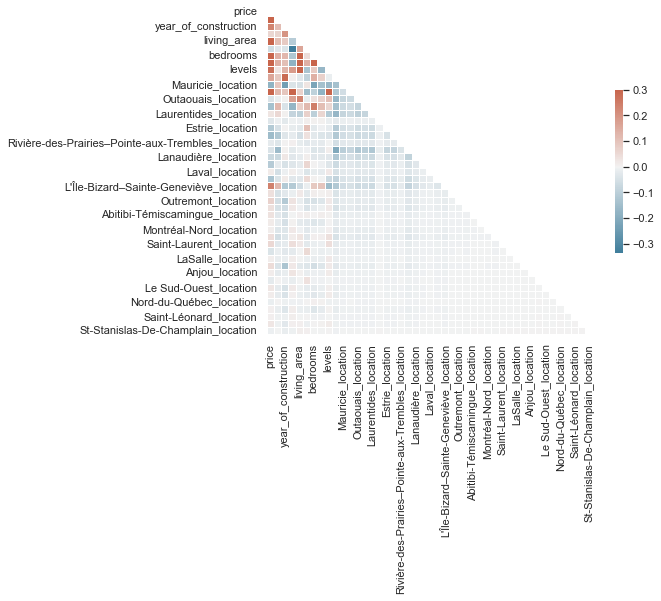

In [883]:
df = X_train.copy()
df.insert(0, 'price', y_train)
plot_corr_map(df)

In [884]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)

0.6622750335397287

# Neural Net

In [885]:
model = Sequential()
model.add(Dense(units=16, activation='tanh', input_shape=(X_train.shape[-1],)))
model.add(Dense(units=8, activation='tanh'))
model.add(Dense(units=4, activation='tanh'))
model.add(Dense(units=1, activation='linear'))

print(model.summary())

model.compile(optimizer=Adam(lr=0.001), loss='mse')

history = model.fit(X_train, y_train, batch_size=1000, epochs=500, shuffle=True, verbose=1, validation_data=(X_test, y_test))

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_136 (Dense)           (None, 16)                720       
                                                                 
 dense_137 (Dense)           (None, 8)                 136       
                                                                 
 dense_138 (Dense)           (None, 4)                 36        
                                                                 
 dense_139 (Dense)           (None, 1)                 5         
                                                                 
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500


c:\Users\simon\Documents\GitHub\quebec-real-estate\venv\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


89/89 [==============================] - 0s 2ms/step - loss: 0.0245 - val_loss: 0.0185
Epoch 2/500
89/89 [==============================] - 0s 1ms/step - loss: 0.0181 - val_loss: 0.0178
Epoch 3/500
89/89 [==============================] - 0s 1ms/step - loss: 0.0160 - val_loss: 0.0126
Epoch 4/500
89/89 [==============================] - 0s 1ms/step - loss: 0.0093 - val_loss: 0.0079
Epoch 5/500
89/89 [==============================] - 0s 1ms/step - loss: 0.0076 - val_loss: 0.0074
Epoch 6/500
89/89 [==============================] - 0s 1ms/step - loss: 0.0071 - val_loss: 0.0073
Epoch 7/500
89/89 [==============================] - 0s 1ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 8/500
89/89 [==============================] - 0s 1ms/step - loss: 0.0066 - val_loss: 0.0069
Epoch 9/500
89/89 [==============================] - 0s 1ms/step - loss: 0.0064 - val_loss: 0.0067
Epoch 10/500
89/89 [==============================] - 0s 1ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 11/500
89/89 [=

In [886]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

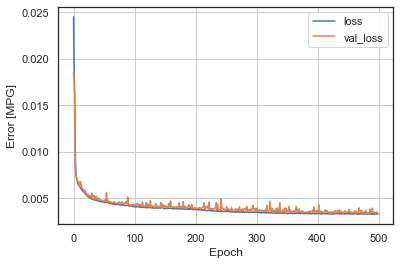

In [887]:
plot_loss(history)

In [888]:
sk_predicted_prices = target_scaler.inverse_transform(reg.predict(X_test))
nnet_predicted_prices = target_scaler.inverse_transform(model.predict(X_test))
real_prices = target_scaler.inverse_transform(y_test)

In [889]:
test_df = X_test.copy()

In [890]:
for col in scaled_cols:
    test_df[col] = scalers[col].inverse_transform(test_df[[col]])

for col in ordinal_cols:
    test_df[col] = ordinal_encoders[col].inverse_transform(test_df[[col]])

In [891]:
d = {}
d['real price'] = list(real_prices)
d['nnet predicted price'] = list(nnet_predicted_prices)
d['sk predicted price'] = list(sk_predicted_prices)

test_df['real price'] = d['real price']
test_df['nnet predicted price'] = d['nnet predicted price']
test_df['sk predicted price'] = d['sk predicted price']

test_df['real price'] = test_df['real price'].astype(int)
test_df['nnet predicted price'] = test_df['nnet predicted price'].astype(int)
test_df['sk predicted price'] = test_df['sk predicted price'].astype(int)

In [892]:
test_df.head(12)

,listing_year,year_of_construction,subtype,living_area,lot_dimensions,bedrooms,bathrooms,levels,Capitale-Nationale_location,Mauricie_location,...,Le Sud-Ouest_location,Verdun_location,Nord-du-Québec_location,Ville-Marie_location,Saint-Léonard_location,Côte-des-Neiges–Notre-Dame-de-Grâce_location,St-Stanislas-De-Champlain_location,real price,nnet predicted price,sk predicted price
55213,2011.0,1977,Bungalow,1100.0,15000.0,2.0,1.0,1.0,0,0,...,0,0,0,0,0,0,0,155000,205105,174208
65441,2008.0,1999,2 Storey,1152.0,2185.0,2.0,1.0,2.0,0,0,...,0,0,0,0,0,0,0,234000,231931,263295
16488,2020.0,1995,Townhouse,1250.0,1092.0,2.0,1.0,2.0,0,0,...,0,0,0,0,0,0,0,250000,241824,242183
79765,2021.0,1989,Semi-detached,2400.0,4471.0,4.0,2.0,2.0,0,0,...,0,0,0,0,0,0,0,360000,367298,410327
49842,2013.0,2013,2 Storey,1500.0,12000.0,3.0,1.0,2.0,0,0,...,0,0,0,0,0,0,0,315000,336880,234018
44615,2015.0,1988,Split Level,1040.0,7000.0,4.0,2.0,1.0,0,0,...,0,0,0,0,0,0,0,208000,198798,146185
22187,2019.0,1970,Bungalow,960.0,6000.0,4.0,2.0,1.0,0,0,...,0,0,0,0,0,0,0,283000,298053,334155
100427,2021.0,2019,Bi-generation,2024.0,17000.0,4.0,3.0,1.0,1,0,...,0,0,0,0,0,0,0,526500,530952,521356
96063,2021.0,1989,Semi-detached,2400.0,4471.0,4.0,2.0,2.0,0,0,...,0,0,0,0,0,0,0,360000,367298,410327
86515,2021.0,1989,Semi-detached,2400.0,4471.0,4.0,2.0,2.0,0,0,...,0,0,0,0,0,0,0,360000,367298,410327


In [893]:
errors = abs(nnet_predicted_prices - real_prices)
errors_small = list(filter(lambda x: x < 100000, errors))
errors_pct = 100 * (abs(nnet_predicted_prices - real_prices) / real_prices)
errors_pct_small = list(filter(lambda x: x < 100, errors_pct))

c:\Users\simon\Documents\GitHub\quebec-real-estate\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

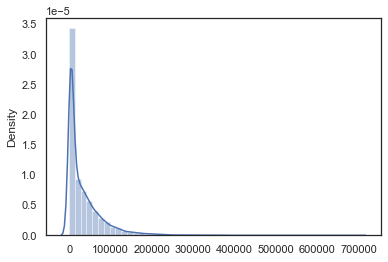

In [894]:
sns.distplot(errors)

c:\Users\simon\Documents\GitHub\quebec-real-estate\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

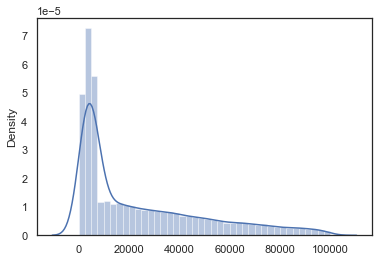

In [895]:
sns.distplot(errors_small)

c:\Users\simon\Documents\GitHub\quebec-real-estate\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

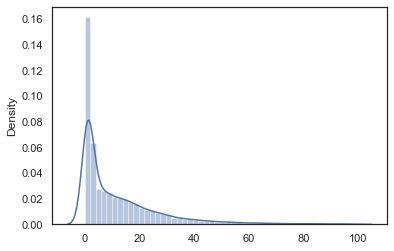

In [896]:
sns.distplot(errors_pct_small)

In [897]:
e_avg = int(np.mean(errors))
e_std = int(np.std(errors))
epct_avg = round(np.mean(errors_pct), 2)
epct_std = round(np.std(errors_pct), 2)

print('Error Mean ($): ' + str(e_avg) + '$')
print('Error std ($): ' + str(e_std) + '$')
print('Error Mean (%): ' + str(epct_avg) + '%')
print('Error std (%): ' + str(epct_std) + '%')

Error Mean ($): 34326$
Error std ($): 46185$
Error Mean (%): 13.24%
Error std (%): 20.67%
